In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["sma","sma_corr"])
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label == "mixed" and portfolio.allocation_type.label == "equal":
            filtered_portfolios.append(portfolio)
print(len(filtered_portfolios))

12


In [8]:
# additional_portfolios = []
# for portfolio in portfolios:
#     if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label != "long_short":
#         for member in Indicator:
#             pm = copy.deepcopy(portfolio)
#             pm.ranking_metric = member.label
#             additional_portfolios.append(pm)

In [9]:
rolling_window = 20
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            # price = Indicator.OPTIMAL.calculate(price,timeframe=rolling_window)
            price = Indicator.SMA.calculate(price,timeframe=rolling_window)
            price = Indicator.SMACorr.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|████████████████████████████████████████████████████████| 11261/11261 [01:48<00:00, 103.66it/s]


In [10]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [11]:
analysises = []
for min_price in tqdm([0.1,0.5,1,2,5]):
    for max_price in [1,2,5,10]:
        filtered_simulation = simulation[(simulation["adjclose"]<=max_price) & (simulation["adjclose"]>=min_price)].copy()
        if filtered_simulation.index.size > 0:
            for portfolio in filtered_portfolios:
                try:
                    trades = portfolio.trades(filtered_simulation.copy())
                    performance = portfolio.portfolio(trades.copy(),benchmark.copy())
                    metrics = KPI.performance(trades,performance)
                    results = {**portfolio.to_dict(),**metrics.copy()}
                    results["portfolio"] = portfolio
                    results["rolling_window"] = rolling_window
                    results["max_price"] = max_price
                    results["min_price"] = min_price
                    analysises.append(results)
                except Exception as e:
                    print(str(e))
                    continue

100%|█████████████████████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.13s/it]


In [12]:
a = pd.DataFrame(analysises)

In [13]:
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values("pnl",ascending=False)
top = a.sort_values("pnl",ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,max_price,min_price
12,sma,long,STANDARD_DEV,mixed,1,1079.319909,26719.158140,0.879995,3.237986,333.330602,1.081096,0.922292,0.490796,1.000233,3.228822,<financial_common.portfolio_management.portfol...,20,2,0.1
0,sma,long,STANDARD_DEV,mixed,1,800.457711,2194.844408,0.895795,3.677023,217.691796,1.067957,0.932448,0.497439,0.999855,3.662991,<financial_common.portfolio_management.portfol...,20,1,0.1
44,sma_corr,long,ROLLING_DOLLAR_VOLUME,mixed,1,693.489286,15040.806513,0.832615,2.202720,314.833175,1.103622,0.900718,0.463937,0.994853,2.192862,<financial_common.portfolio_management.portfol...,20,10,0.1
92,sma_corr,long,ROLLING_DOLLAR_VOLUME,mixed,1,671.430258,21344.201077,0.755894,2.223360,301.989022,1.102855,0.902545,0.469572,0.996605,2.213083,<financial_common.portfolio_management.portfol...,20,10,0.5
86,sma,long,ROLLING_DOLLAR_VOLUME,mixed,1,554.825835,20878.598038,0.755894,2.693789,205.964870,1.102490,0.902200,0.467693,0.995875,2.678720,<financial_common.portfolio_management.portfol...,20,10,0.5
18,sma_corr,long,STANDARD_DEV,mixed,1,512.978663,11824.236436,0.879995,2.856412,179.588498,1.082800,0.922715,0.487791,1.000803,2.839402,<financial_common.portfolio_management.portfol...,20,2,0.1
6,sma_corr,long,STANDARD_DEV,mixed,1,457.574311,980.796737,0.722643,2.895472,158.031001,1.068631,0.932052,0.493499,0.999454,2.876142,<financial_common.portfolio_management.portfol...,20,1,0.1
11,sma_corr,long,DISTANCE,mixed,1,441.806497,932.366013,0.871536,4.182047,105.643611,1.065568,0.931682,0.489165,0.997174,4.153214,<financial_common.portfolio_management.portfol...,20,1,0.1
17,sma,long,DISTANCE,mixed,1,403.415545,11622.318542,0.886277,2.067208,195.149999,1.076044,0.925226,0.476521,0.997094,2.051555,<financial_common.portfolio_management.portfol...,20,2,0.1
22,sma_corr,long,DRAWDOWN,mixed,1,367.175496,1882.502192,0.788732,2.771937,132.461712,1.064373,0.928489,0.499061,0.996304,2.748876,<financial_common.portfolio_management.portfol...,20,2,0.1


In [14]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [15]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

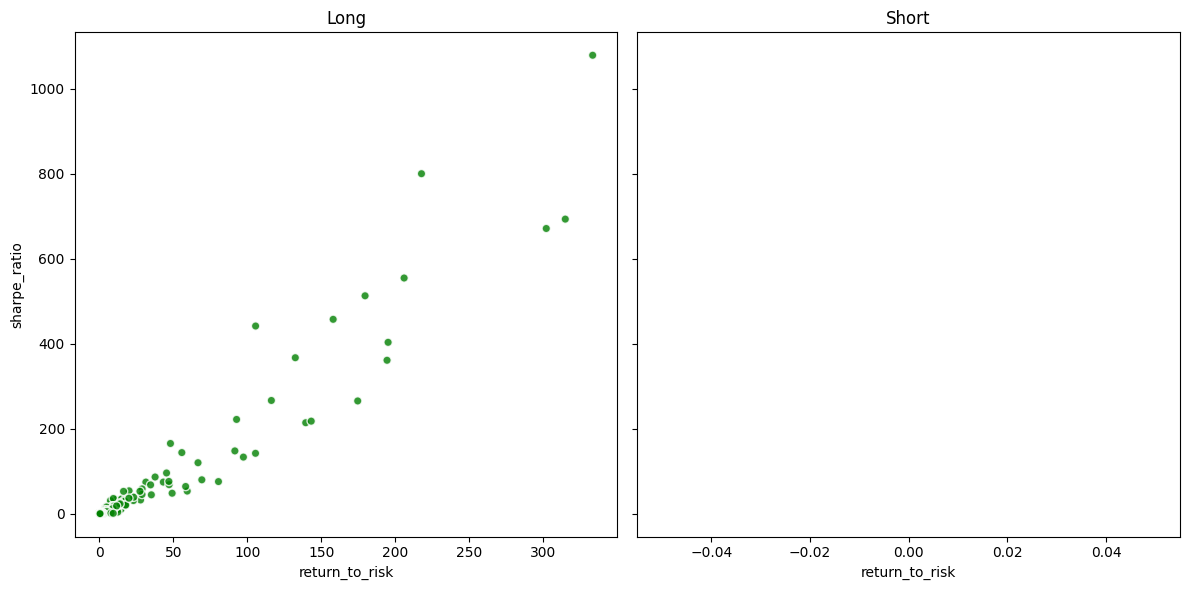

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [17]:
pm = top["portfolio"]
filtered_simulation = simulation[(simulation["adjclose"]<=top["max_price"]) & (simulation["adjclose"]>=top["min_price"])]
trades = pm.trades(filtered_simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

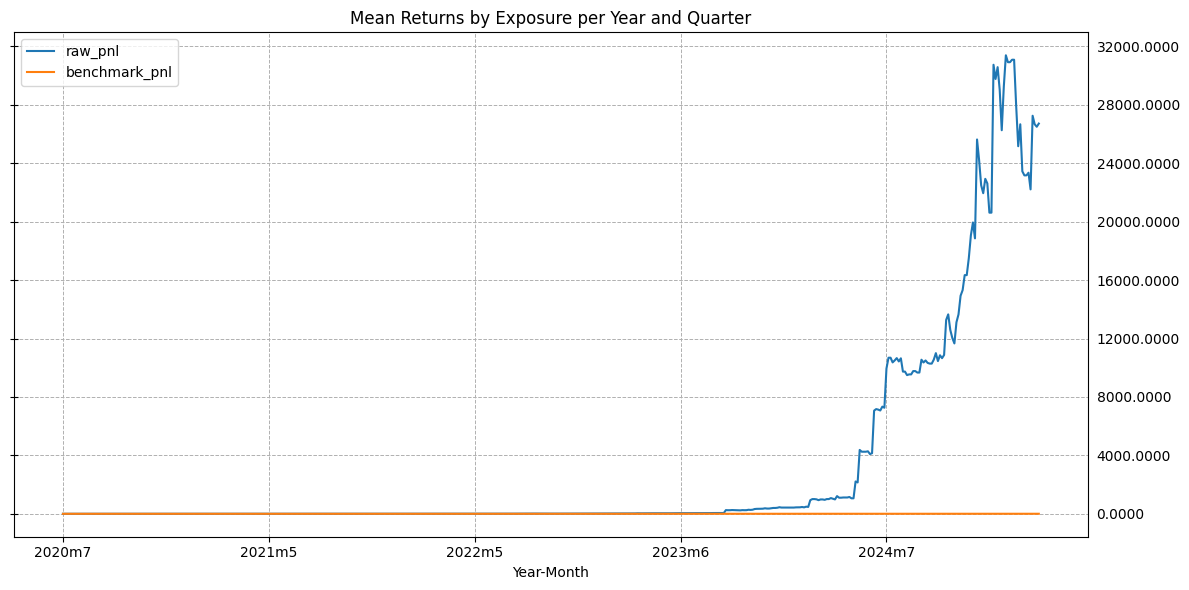

In [18]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [19]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
ADIL,1.428392
IAUX,1.428392
GOVX,1.428392
AMTX,1.387324
SISI,1.296660
...,...
SGLY,0.748486
MAIA,0.733333
MULN,0.726160


In [20]:
len(filtered_simulation["ticker"].unique())

1092

In [21]:
trades.sort_values("return",ascending=False).dropna().head(20)

,year,week,ticker,date,adjclose,sell_price,standard_dev,sma,risk,group_percentile,rank_percentile,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter
major_key,,,,,,,,,,,,,,,,,,,,
2024_26_1.0,2024,26,OPTT,2024-06-28 00:00:00+00:00,0.1356,0.1958,0.024416,0.245154,0.153770,1.0,0.043,1.0,1,1.443953,1.443953,1.428392,1.443953,1.428392,6,2
2023_32_0.6,2023,32,RENB,2023-08-11 00:00:00+00:00,0.7520,1.5600,0.056117,-0.151475,0.104628,0.6,1.000,1.0,1,2.074468,2.074468,1.428392,2.074468,1.428392,8,3
2023_36_0.1,2023,36,PW,2023-09-08 00:00:00+00:00,1.0250,1.8000,0.247366,0.353411,0.195772,0.1,0.034,1.0,1,1.756098,1.756098,1.428392,1.756098,1.428392,9,3
2024_25_0.2,2024,25,GOVX,2024-06-20 00:00:00+00:00,1.1100,1.8900,0.162175,0.379725,0.124444,0.2,0.023,1.0,1,1.702703,1.702703,1.428392,1.702703,1.428392,6,2
2024_28_0.4,2024,28,SGMO,2024-07-12 00:00:00+00:00,0.3184,0.4548,0.100333,0.415845,0.224800,0.4,0.023,1.0,1,1.428392,1.428392,1.428392,1.428392,1.428392,7,3
2024_21_0.8,2024,21,ONMD,2024-05-23 00:00:00+00:00,0.4700,1.4700,0.048959,0.203075,0.092753,0.8,0.025,1.0,1,3.127660,3.127660,1.428392,3.127660,1.428392,5,2
2025_20_0.8,2025,20,GORV,2025-05-16 00:00:00+00:00,0.1460,0.2191,0.034407,0.422133,0.175988,0.8,0.014,1.0,1,1.500685,1.500685,1.428392,1.500685,1.428392,5,2
2024_27_0.8,2024,27,QUBT,2024-07-05 00:00:00+00:00,0.4205,0.6062,0.050461,0.276344,0.107288,0.8,0.023,1.0,1,1.441617,1.441617,1.428392,1.441617,1.428392,7,3
2022_20_0.4,2022,20,NMTC,2022-05-20 00:00:00+00:00,0.5820,0.9208,0.178236,0.447896,0.231226,0.4,0.062,1.0,1,1.582131,1.582131,1.428392,1.582131,1.428392,5,2


In [22]:
portfolio.sort_values("weighted_return",ascending=False)

,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,year,month,quarter,week,Year-Month
322,2023-09-28 00:00:00+00:00,4.583836,1.428392,63.453133,253.325355,141.43,1.614682,2023,9,3,39,2023m9
385,2024-05-16 00:00:00+00:00,2.085714,1.428392,260.125742,2213.442992,197.80,2.258249,2024,5,2,20,2024m5
387,2024-05-23 00:00:00+00:00,2.035349,1.185715,299.423026,4373.496082,192.38,2.196369,2024,5,2,21,2024m5
363,2024-02-28 00:00:00+00:00,1.975369,1.428392,160.023703,932.667180,179.08,2.044526,2024,2,1,9,2024m2
394,2024-06-20 00:00:00+00:00,1.702703,1.428392,405.754116,7064.768080,194.09,2.215892,2024,6,2,25,2024m6
...,...,...,...,...,...,...,...,...,...,...,...,...
456,2025-02-28 00:00:00+00:00,0.904185,0.921011,1174.081764,26262.940902,262.90,3.001484,2025,2,1,9,2025m2
464,2025-03-28 00:00:00+00:00,0.900453,0.909725,1097.323484,25168.387517,241.24,2.754196,2025,3,1,13,2025m3
463,2025-03-27 00:00:00+00:00,0.898998,0.898998,1206.214262,27950.811944,246.48,2.814020,2025,3,1,13,2025m3
238,2022-09-23 00:00:00+00:00,0.879995,0.879995,11.168380,11.580872,101.39,1.157552,2022,9,3,38,2022m9
